In [1]:
%%time
import os
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import train_test_split, KFold
from torchvision import transforms
from PIL import Image
from transformers import SegformerForSemanticSegmentation, SegformerConfig, SegformerImageProcessor
import tkinter as tk
from tkinter import filedialog
import tensorflow as tf
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score, precision_score, recall_score, f1_score, accuracy_score
from transformers import SamModel, SamProcessor
from torch import nn
from scipy.ndimage import label, find_objects
from sklearn.model_selection import StratifiedKFold
from datetime import datetime

# DataSet
class SplashDataSet_train_val_0501(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.images_dir = os.path.join(self.root_dir, "images")
        self.masks_dir = os.path.join(self.root_dir, "annotations")
        # get filenames
        self.images_list = sorted(os.listdir(self.images_dir))
        self.masks_list = sorted(os.listdir(self.masks_dir))
        assert len(self.images_list) == len(self.masks_list), "Number of images and annotations should be the same."

        # transform image to 1024*1024
        self.transform = transforms.Compose([
            transforms.Resize((1024, 1024)),
            transforms.ToTensor(),  # This will scale pixel values to [0, 1]
        ])
    def __len__(self):
        return len(self.images_list)

    def __getitem__(self, idx):
        # get image and annotation file
        img_path = os.path.join(self.images_dir, self.images_list[idx])
        mask_path = os.path.join(self.masks_dir, self.masks_list[idx])
        
        image = Image.open(img_path)
        mask = Image.open(mask_path)
        
        image = self.transform(image)
        mask = self.transform(mask)

        # Convert mask to binary 0 and 1
        mask = (mask > 0).to(torch.int)
        mask = mask[0, None, :, :]
        
        return image, mask

    def get_time_category(self, filename):
        # my filenames' format is 2024-04-09-03-00-11.png
        time_str = filename.split('-')[3:5]
        time_obj = datetime.strptime('-'.join(time_str), '%H-%M')
        hour = time_obj.hour
        if hour < 8:
            return 'morning'
        elif 8 <= hour <= 16:
            return 'day'
        else:
            return 'evening'

def focal_loss(inputs, targets, alpha=0.25, gamma=2.0, reduction='mean'):
    #print("inputs size = ", inputs.size())
    # inputs size =  torch.Size([1, 2, 1024, 1024])
    #print("targets size = ", targets.size())
    # targets size =  torch.Size([1, 1024, 1024])
    BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
    targets = targets.type(torch.float32)
    at = alpha * targets + (1 - alpha) * (1 - targets)
    pt = torch.exp(-BCE_loss)
    F_loss = at * (1 - pt)**gamma * BCE_loss

    if reduction == 'mean':
        return torch.mean(F_loss), (1 - pt)**gamma
    elif reduction == 'sum':
        return torch.sum(F_loss)
    else:
        return F_loss

# criterion
def criterion(outputs, labels):
    return torch.nn.functional.cross_entropy(outputs, labels.squeeze(1).long())

def KD_criterion(student_outputs, teacher_outputs, labels, teacher_ratio, temperature):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    #print("student_outputs size = ", student_outputs.size())
    # print("student_outputs = ", student_outputs["out"])
    #print("teacher_outputs size = ", teacher_outputs.size())
    # print("teacher_outputs = ", teacher_outputs)
    #print("ground truth size = ", labels.size())
    
    # Calculate Cross Entropy
    # original_loss = torch.nn.functional.cross_entropy(student_outputs, labels.squeeze(1).long())

    # Calculate Focal Loss , not sure about alpha and gamme
    #original_loss = focal_loss(student_outputs[:,1,:,:], labels.squeeze(1).float(), alpha=0.25, gamma=2.0)
    alpha=0.25
    gamma=2.0
    targets = labels.squeeze(1).float()
    BCE_loss = F.binary_cross_entropy_with_logits(student_outputs[:,1,:,:], targets, reduction='none')
    targets = targets.type(torch.float32)
    at = alpha * targets + (1 - alpha) * (1 - targets)
    pt = torch.exp(-BCE_loss)
    modulating_number = torch.mean((1 - pt)**gamma)
    F_loss = at * modulating_number * BCE_loss
    #print("modulating_number = ", modulating_number)
    # mean
    original_loss = torch.mean(F_loss)
    #print("original loss = ", original_loss)

    # Calculate Distillation Loss
    soft_teacher_outputs = torch.softmax(teacher_outputs[0, 0, :, :] / temperature, dim=1)
    soft_student_outputs = torch.log_softmax(student_outputs[0, 0, :, :] / temperature, dim=1)
    distillation_loss = nn.KLDivLoss()(soft_student_outputs.to(device), soft_teacher_outputs.to(device))
    #print("distillation loss = ", distillation_loss)
    
    # total loss
    #total_loss = modulating_number*((1-teacher_ratio)*original_loss + teacher_ratio*distillation_loss)
    total_loss = (1-teacher_ratio)*original_loss + teacher_ratio*distillation_loss*modulating_number
    return total_loss

# evaluate
def evaluate(model, val_loader, device):
    model.eval()
    model.to(device)
    total_loss = 0.0
    with torch.no_grad():
        for image, mask in val_loader:
            image, mask = image.to(device), mask.to(device)

            outputs = model(image)

            loss = criterion(outputs['out'], mask)

            # Calculate Focal Loss , not sure about alpha and gamme
            #print("outputs size = ", outputs['out'].size())
            #print("mask size = ", mask.size())
            # outputs['out'] size =  torch.Size([1, 2, 1024, 1024])
            # mask size =  torch.Size([1, 1, 1024, 1024])
            #loss = focal_loss(outputs['out'][:,1:2,:,:], mask.float())
            total_loss += loss.item()
    avg_loss = total_loss / len(val_loader)
    print(f"Average validation loss: {avg_loss}")
    return avg_loss

# train every epoch
def train_one_epoch(student_model, teacher_model, teacher_image_processor, data_loader, teacher_ratio, temperature, optimizer, device, pbar):
    student_model.to(device)
    student_model.train()
    teacher_model.to(device)
    teacher_model.eval()
    training_loss = []
    for idx, (image, mask) in enumerate(data_loader):
        #bbox = [[[get_bounding_box(np.array(mask))]]]
        bbox, point = get_bounding_box_and_center(np.array(mask))
        #print("[train_one_epoch] bbox = ", bbox)
        #print("[train_one_epoch] point = ", point)
        image, mask = image.to(device), mask.to(device)
        # image size = torch.Size([1, 3, 1024, 1024])start_step
        # mask size = torch.Size([1, 1, 1024, 1024])

        optimizer.zero_grad()
        # output for student model ----------------------------------------------------------
        student_outputs = student_model(image)
        # outputs size = torch.Size([1, 2, 1024, 1024])
        # -----------------------------------------------------------------------------------
        # output for teacher model ----------------------------------------------------------
        # Retrieve the image embeddings
        # processor
        teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        teacher_image_embeddings = teacher_model.get_image_embeddings(teacher_inputs["pixel_values"])
        
        # 送到processor計算遮罩
        if bbox is None:
            teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        else:
            teacher_inputs = teacher_image_processor(image, input_points=[[[point]]], input_boxes=[[[bbox]]], return_tensors="pt", do_rescale=False).to(device)

        teacher_inputs.pop("pixel_values", None)
        teacher_inputs.update({"image_embeddings": teacher_image_embeddings})

        teacher_outputs = teacher_model(**teacher_inputs)
        teacher_masks, teacher_output = teacher_image_processor.image_processor.post_process_masks(teacher_outputs.pred_masks.cpu(), teacher_inputs["original_sizes"].cpu(), teacher_inputs["reshaped_input_sizes"].cpu())  
        # -----------------------------------------------------------------------------------
        #loss = criterion(student_outputs, mask)
        loss = KD_criterion(student_outputs['out'], teacher_output[0], mask, teacher_ratio, temperature)
        loss.backward()
        optimizer.step()
        """
        [train_one_epoch] image size =  torch.Size([1, 3, 1024, 1024])
        [train_one_epoch]0 mask size =  torch.Size([1, 1, 1024, 1024])
        [train_one_epoch]0 outputs size =  torch.Size([1, 2, 128, 128])
        [train_one_epoch]1 outputs size =  torch.Size([1, 2, 1024, 1024])
        """
        training_loss.append(loss.item())
        pbar.update(idx + 1, values=[("loss", loss.item())])
    return np.mean(np.array(training_loss))

# train
def train(model, teacher_model, teacher_image_processor, train_loader, val_loader, train_size, save_model, teacher_ratio=0.7, temperature=1):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device, ":",torch.cuda.get_device_name(0))

    train_losses   = []
    val_losses     = []
    epochs = 10
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    best_val_loss = float('inf')

    n_batch = len(train_loader)
    pbar = tf.keras.utils.Progbar(target=n_batch, stateful_metrics=None)
    ######### weight
    # 動態生成儲存模型權重的檔名，加入目前使用的資料集大小的數字
    weight_filename = f"segformer_data_size_{train_size}.pth"
    # 確定weights資料夾是否存在，如果不存在則新增它
    #weights_dir = os.path.join(os.getcwd(),"weights")
    weights_dir = os.path.join(os.getcwd(), f"weights/weights_KD_segformer_0616/weights_KD_segformer_0616_{int(teacher_ratio*100)}")
    if not os.path.exists(weights_dir):
        os.makedirs(weights_dir)
    model_pathname = os.path.join(weights_dir, weight_filename)
    ######### weight end
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        
        train_loss = train_one_epoch(model, teacher_model, teacher_image_processor, train_loader, teacher_ratio, temperature, optimizer, device, pbar)
        train_losses.append(train_loss)

        if val_loader is not None:
            val_loss = evaluate(model, val_loader, device)
            val_losses.append(val_loss)
            pbar.update(n_batch, values=[('val_loss', val_loss)])

            if val_loss < best_val_loss and save_model:
                best_val_loss = val_loss
                torch.save(model.state_dict(), model_pathname)
                print(f"Saved model weights to '{model_pathname}'.")
    print(f"Train loss: {np.mean(train_losses)}, Validation loss: {np.mean(val_losses)}" if val_loader is not None else f"Train loss: {np.mean(train_losses)}")
    return {'loss':train_losses, 'val_loss':val_losses}

def select_folder():
    root = tk.Tk()
    root.withdraw()
    parent_folder = filedialog.askdirectory(title="選擇資料夾")
    return parent_folder

def get_bounding_box(ground_truth_map):
  ground_truth_map = ground_truth_map[0, 0, :, :]
  #print("ground_truth_map = ", ground_truth_map.shape)
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

def get_bounding_box_and_center(ground_truth_map):
    #print("[get_bounding_box_and_center]")
    ground_truth_map = ground_truth_map[0, 0, :, :]
    if np.any(ground_truth_map > 0):
        # get bounding box from mask
        y_indices, x_indices = np.where(ground_truth_map > 0)
        x_min, x_max = np.min(x_indices), np.max(x_indices)
        y_min, y_max = np.min(y_indices), np.max(y_indices)
        # add perturbation to bounding box coordinates
        H, W = ground_truth_map.shape
        x_min = max(0, x_min - np.random.randint(0, 20))
        x_max = min(W, x_max + np.random.randint(0, 20))
        y_min = max(0, y_min - np.random.randint(0, 20))
        y_max = min(H, y_max + np.random.randint(0, 20))
        bbox = [x_min, y_min, x_max, y_max]

        # Identify the largest connected component (largest mask area)
        labeled_array, num_features = label(ground_truth_map > 0)
        if num_features > 0:
            # Find the largest component
            max_label = 1 + np.argmax([np.sum(labeled_array == i) for i in range(1, num_features+1)])
            # Get the slice for the largest component
            largest_component_slice = find_objects(labeled_array == max_label)[0]
            yc, xc = largest_component_slice
            center_x = xc.start + (xc.stop - xc.start) // 2
            center_y = yc.start + (yc.stop - yc.start) // 2
            center_point = (center_x, center_y)
        else:
            center_point = ((x_min + x_max) // 2, (y_min + y_max) // 2)
    else:
        bbox = None
        center_point = None
    return bbox, center_point

class MySegFormer_0604(nn.Module):
    def __init__(self,num_classes,backbone="b0",id2label=None):
        super().__init__()
        self.num_classes = num_classes
        if id2label is not None:
            self.id2label = id2label
        else:
            self.id2label = {i:str(i) for i in range(self.num_classes)}
        self.segformer = SegformerForSemanticSegmentation.from_pretrained(f"nvidia/mit-{backbone}",
                                                         num_labels=self.num_classes, 
                                                         id2label=self.id2label, 
                                                         label2id={v:k for k,v in self.id2label.items()}
                                                         , ignore_mismatched_sizes=True)
    def forward(self,x):
        y = self.segformer(x)
        y = nn.functional.interpolate(y.logits, size=x.shape[-2:], mode="bilinear", align_corners=False,antialias=True)        
        return {'out':y}
        # 在conda 環境裡huggingface包好的Segformer有改(modeling_segformer.py)

# Student Model: Segformer 0601
backbone = "b0"
num_classes = 2
model_segformer = MySegFormer_0604(num_classes, backbone)

# Teacher Model: Segment Anything Model
model_sam = SamModel.from_pretrained("facebook/sam-vit-huge")
processor_sam = SamProcessor.from_pretrained("facebook/sam-vit-huge")

train_sizes = [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
#train_sizes = [300]
# 放所有 fold 的 平均、標準差
mean_val_losses = []
std_val_losses = []
root_dir = select_folder()

#root_dir = "C:/Users/user/Desktop/NAS_data/鱸魚/高雄黃明和/train_0418"
#print(root_dir)

# My DataSet, return image, mask
train_val_dataset = SplashDataSet_train_val_0501(root_dir=root_dir)
labels = [train_val_dataset.get_time_category(filename) for filename in train_val_dataset.images_list]
#print("indices 1= ", indices)
#print("label size = ", label.size())
#print("label = ", len(labels))
#print("len(train_val_dataset = )", len(train_val_dataset))
for train_size in train_sizes:
    # 在前一個大小的資料袋中擴增資料(train+validation)
    indices = np.arange(len(train_val_dataset))
    indices = indices[:train_size]
    # print("indices = ", indices)
    # Stratified K-Fold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    val_losses = []  # 放每個 fold 的 validation loss
    for fold, (train_idx, val_idx) in enumerate(skf.split(indices, [labels[i] for i in indices])):
        print(f'FOLD {fold+1}')
        print('--------------------------------')
        train_idx = indices[train_idx]
        val_idx = indices[val_idx]
        """
        for i in indices:
            print("i = ", i)
            print("labels[i] = ", labels[i])
        print("----")
        """
        
        train_subset = Subset(train_val_dataset, train_idx)
        val_subset = Subset(train_val_dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=1, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=1, shuffle=False)
        # train
        # Please replace Diatillation_Loss_Ratio to the teacher_ratio from 0 ~ 1 
        teacher_ratio = 1
        temperature = 5
        lc = train(model_segformer, model_sam, processor_sam, train_loader, val_loader, train_size, True, teacher_ratio, temperature)

        val_loss = lc['val_loss']
        val_losses.append(val_loss)
    mean_val_losses.append(np.mean(val_losses))
    std_val_losses.append(np.std(val_losses))


c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should pro

FOLD 1
--------------------------------
cuda : NVIDIA GeForce RTX 4090
Epoch 1/10
1/4 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - loss: 1.8233e-04

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 927ms/step - loss: 1.2862e-04
Average validation loss: 0.6826107501983643
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 937ms/step - loss: 1.2862e-04 - val_loss: 0.6826
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_100\segformer_data_size_5.pth'.
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 850ms/step - loss: 9.5839e-05 - val_loss: 0.6826
Average validation loss: 0.6227113008499146
4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 864ms/step - loss: 9.5839e-05 - val_loss: 0.6527
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_100\segformer_data_size_5.pth'.
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 818ms/step - loss: 7.6353e-05 - val_loss: 0.6527
Average validation loss: 0.5850286483764648
4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 829ms/step - loss: 7.6353e-05 - val_loss: 0.6301
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_seg

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 772ms/step - loss: 7.3364e-07
Average validation loss: 0.052226776257157326
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 781ms/step - loss: 7.3364e-07 - val_loss: 0.0522
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_100\segformer_data_size_10.pth'.
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 774ms/step - loss: 6.3366e-07 - val_loss: 0.0522
Average validation loss: 0.04131046123802662
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 781ms/step - loss: 6.3366e-07 - val_loss: 0.0468
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_100\segformer_data_size_10.pth'.
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 19s 788ms/step - loss: 5.6727e-07 - val_loss: 0.0468
Average validation loss: 0.024901275523006916
8/8 ━━━━━━━━━━━━━━━━━━━━ 19s 798ms/step - loss: 5.6727e-07 - val_loss: 0.0395
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weigh

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 770ms/step - loss: 3.4841e-07
Average validation loss: 0.03464654895166556
12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 781ms/step - loss: 3.4841e-07 - val_loss: 0.0346
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_100\segformer_data_size_15.pth'.
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 19s 768ms/step - loss: 3.2179e-07 - val_loss: 0.0346
Average validation loss: 0.023721608022848766
12/12 ━━━━━━━━━━━━━━━━━━━━ 19s 779ms/step - loss: 3.2179e-07 - val_loss: 0.0292
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_100\segformer_data_size_15.pth'.
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 28s 797ms/step - loss: 2.7470e-07 - val_loss: 0.0292
Average validation loss: 0.01875156071037054
12/12 ━━━━━━━━━━━━━━━━━━━━ 28s 807ms/step - loss: 2.7470e-07 - val_loss: 0.0257
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\we

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 770ms/step - loss: 2.9847e-07
Average validation loss: 0.030043504666537046
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 780ms/step - loss: 2.9847e-07 - val_loss: 0.0300
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_100\segformer_data_size_20.pth'.
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 25s 759ms/step - loss: 2.2273e-07 - val_loss: 0.0300
Average validation loss: 0.030575933400541544
16/16 ━━━━━━━━━━━━━━━━━━━━ 25s 769ms/step - loss: 2.2273e-07 - val_loss: 0.0303
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 38s 799ms/step - loss: 1.9929e-07 - val_loss: 0.0303
Average validation loss: 0.029669913230463862
16/16 ━━━━━━━━━━━━━━━━━━━━ 38s 809ms/step - loss: 1.9929e-07 - val_loss: 0.0301
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_100\segformer_data_size_20.pth'.
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 51s 809ms/step - loss: 1.

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 774ms/step - loss: 1.9321e-07
Average validation loss: 0.028042212408035994
20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 786ms/step - loss: 1.9321e-07 - val_loss: 0.0280
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_100\segformer_data_size_25.pth'.
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 31s 760ms/step - loss: 1.5988e-07 - val_loss: 0.0280
Average validation loss: 0.03145928466692567
20/20 ━━━━━━━━━━━━━━━━━━━━ 31s 772ms/step - loss: 1.5988e-07 - val_loss: 0.0298
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 47s 760ms/step - loss: 1.3860e-07 - val_loss: 0.0298
Average validation loss: 0.036016647890210154
20/20 ━━━━━━━━━━━━━━━━━━━━ 47s 772ms/step - loss: 1.3860e-07 - val_loss: 0.0318
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 62s 755ms/step - loss: 1.2756e-07 - val_loss: 0.0318
Average validation loss: 0.028823536355048418
20/20 ━━━━━━━━━━━━━━━━━━━━ 62s 767ms/step - loss: 1.2756e-07 - val_loss: 0.0311
Epoch

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


24/24 ━━━━━━━━━━━━━━━━━━━━ 19s 771ms/step - loss: 4.3163e-07
Average validation loss: 0.03416046034544706
24/24 ━━━━━━━━━━━━━━━━━━━━ 19s 783ms/step - loss: 4.3163e-07 - val_loss: 0.0342
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_100\segformer_data_size_30.pth'.
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 37s 769ms/step - loss: 3.6847e-07 - val_loss: 0.0342
Average validation loss: 0.01974806950117151
24/24 ━━━━━━━━━━━━━━━━━━━━ 38s 780ms/step - loss: 3.6847e-07 - val_loss: 0.0270
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_100\segformer_data_size_30.pth'.
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 56s 772ms/step - loss: 2.9779e-07 - val_loss: 0.0270
Average validation loss: 0.031618024688214064
24/24 ━━━━━━━━━━━━━━━━━━━━ 56s 784ms/step - loss: 2.9779e-07 - val_loss: 0.0285
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 76s 804ms/step - loss: 2.54

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


40/40 ━━━━━━━━━━━━━━━━━━━━ 31s 784ms/step - loss: 3.5295e-07
Average validation loss: 0.04749373034574091
40/40 ━━━━━━━━━━━━━━━━━━━━ 32s 797ms/step - loss: 3.5295e-07 - val_loss: 0.0475
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_100\segformer_data_size_50.pth'.
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 67s 885ms/step - loss: 2.7744e-07 - val_loss: 0.0475
Average validation loss: 0.051350791938602924
40/40 ━━━━━━━━━━━━━━━━━━━━ 68s 898ms/step - loss: 2.7744e-07 - val_loss: 0.0494
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 100s 807ms/step - loss: 2.4164e-07 - val_loss: 0.0494
Average validation loss: 0.10197566915303469
40/40 ━━━━━━━━━━━━━━━━━━━━ 101s 820ms/step - loss: 2.4164e-07 - val_loss: 0.0669
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 133s 807ms/step - loss: 2.2389e-07 - val_loss: 0.0669
Average validation loss: 0.06515234922990203
40/40 ━━━━━━━━━━━━━━━━━━━━ 133s 820ms/step - loss: 2.2389e-07 - val_loss: 0.0665
Epo

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


48/48 ━━━━━━━━━━━━━━━━━━━━ 40s 827ms/step - loss: 1.4405e-07
Average validation loss: 0.023195476096589118
48/48 ━━━━━━━━━━━━━━━━━━━━ 40s 839ms/step - loss: 1.4405e-07 - val_loss: 0.0232
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_100\segformer_data_size_60.pth'.
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 78s 777ms/step - loss: 1.3065e-07 - val_loss: 0.0232
Average validation loss: 0.02385780942859128
48/48 ━━━━━━━━━━━━━━━━━━━━ 78s 787ms/step - loss: 1.3065e-07 - val_loss: 0.0235
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 116s 778ms/step - loss: 1.1806e-07 - val_loss: 0.0235
Average validation loss: 0.021586715903443594
48/48 ━━━━━━━━━━━━━━━━━━━━ 116s 789ms/step - loss: 1.1806e-07 - val_loss: 0.0229
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_100\segformer_data_size_60.pth'.
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 155s 810ms/step - loss: 

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


56/56 ━━━━━━━━━━━━━━━━━━━━ 50s 889ms/step - loss: 2.2196e-07
Average validation loss: 0.03584861066857619
56/56 ━━━━━━━━━━━━━━━━━━━━ 50s 901ms/step - loss: 2.2196e-07 - val_loss: 0.0358
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_100\segformer_data_size_70.pth'.
Epoch 2/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 101s 898ms/step - loss: 1.9782e-07 - val_loss: 0.0358
Average validation loss: 0.02845613209397665
56/56 ━━━━━━━━━━━━━━━━━━━━ 101s 909ms/step - loss: 1.9782e-07 - val_loss: 0.0322
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_100\segformer_data_size_70.pth'.
Epoch 3/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 149s 843ms/step - loss: 1.6736e-07 - val_loss: 0.0322
Average validation loss: 0.03150374917978687
56/56 ━━━━━━━━━━━━━━━━━━━━ 149s 854ms/step - loss: 1.6736e-07 - val_loss: 0.0319
Epoch 4/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 195s 824ms/step - loss: 

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


64/64 ━━━━━━━━━━━━━━━━━━━━ 49s 768ms/step - loss: 7.3348e-08
Average validation loss: 0.041022168850759044
64/64 ━━━━━━━━━━━━━━━━━━━━ 50s 780ms/step - loss: 7.3348e-08 - val_loss: 0.0410
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_100\segformer_data_size_80.pth'.
Epoch 2/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 101s 799ms/step - loss: 6.7220e-08 - val_loss: 0.0410
Average validation loss: 0.03576273893122561
64/64 ━━━━━━━━━━━━━━━━━━━━ 102s 809ms/step - loss: 6.7220e-08 - val_loss: 0.0384
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_100\segformer_data_size_80.pth'.
Epoch 3/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 153s 801ms/step - loss: 6.1458e-08 - val_loss: 0.0384
Average validation loss: 0.056708626201725565
64/64 ━━━━━━━━━━━━━━━━━━━━ 154s 812ms/step - loss: 6.1458e-08 - val_loss: 0.0445
Epoch 4/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 208s 849ms/step - loss

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


72/72 ━━━━━━━━━━━━━━━━━━━━ 56s 772ms/step - loss: 8.9378e-08
Average validation loss: 0.05019590685454508
72/72 ━━━━━━━━━━━━━━━━━━━━ 56s 783ms/step - loss: 8.9378e-08 - val_loss: 0.0502
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_100\segformer_data_size_90.pth'.
Epoch 2/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 114s 806ms/step - loss: 6.6639e-08 - val_loss: 0.0502
Average validation loss: 0.054113184877981745
72/72 ━━━━━━━━━━━━━━━━━━━━ 115s 817ms/step - loss: 6.6639e-08 - val_loss: 0.0522
Epoch 3/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 173s 802ms/step - loss: 5.5717e-08 - val_loss: 0.0522
Average validation loss: 0.04665618074230022
72/72 ━━━━━━━━━━━━━━━━━━━━ 174s 814ms/step - loss: 5.5717e-08 - val_loss: 0.0503
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_100\segformer_data_size_90.pth'.
Epoch 4/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 231s 790ms/step - loss:

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


80/80 ━━━━━━━━━━━━━━━━━━━━ 64s 800ms/step - loss: 8.6857e-08
Average validation loss: 0.03319518322823569
80/80 ━━━━━━━━━━━━━━━━━━━━ 65s 812ms/step - loss: 8.6857e-08 - val_loss: 0.0332
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_100\segformer_data_size_100.pth'.
Epoch 2/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 130s 812ms/step - loss: 7.4793e-08 - val_loss: 0.0332
Average validation loss: 0.03234492077026516
80/80 ━━━━━━━━━━━━━━━━━━━━ 131s 824ms/step - loss: 7.4793e-08 - val_loss: 0.0328
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_100\segformer_data_size_100.pth'.
Epoch 3/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 194s 788ms/step - loss: 6.2679e-08 - val_loss: 0.0328
Average validation loss: 0.02839043701533228
80/80 ━━━━━━━━━━━━━━━━━━━━ 195s 800ms/step - loss: 6.2679e-08 - val_loss: 0.0313
Saved model weights to 'c:\天_11157065\git\RipplesDetection\a

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


96/96 ━━━━━━━━━━━━━━━━━━━━ 84s 872ms/step - loss: 1.2114e-07
Average validation loss: 0.054608154498661556
96/96 ━━━━━━━━━━━━━━━━━━━━ 85s 884ms/step - loss: 1.2114e-07 - val_loss: 0.0546
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_100\segformer_data_size_120.pth'.
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 164s 829ms/step - loss: 1.0654e-07 - val_loss: 0.0546
Average validation loss: 0.04200637515168637
96/96 ━━━━━━━━━━━━━━━━━━━━ 165s 841ms/step - loss: 1.0654e-07 - val_loss: 0.0483
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_100\segformer_data_size_120.pth'.
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 243s 807ms/step - loss: 9.2888e-08 - val_loss: 0.0483
Average validation loss: 0.04246094300954913
96/96 ━━━━━━━━━━━━━━━━━━━━ 244s 819ms/step - loss: 9.2888e-08 - val_loss: 0.0464
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 319s 782ms/step - los

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


120/120 ━━━━━━━━━━━━━━━━━━━━ 98s 821ms/step - loss: 1.8489e-07
Average validation loss: 0.01918255771500602
120/120 ━━━━━━━━━━━━━━━━━━━━ 100s 832ms/step - loss: 1.8489e-07 - val_loss: 0.0192
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_100\segformer_data_size_150.pth'.
Epoch 2/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 202s 846ms/step - loss: 1.4140e-07 - val_loss: 0.0192
Average validation loss: 0.023967127537859293
120/120 ━━━━━━━━━━━━━━━━━━━━ 203s 858ms/step - loss: 1.4140e-07 - val_loss: 0.0216
Epoch 3/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 306s 859ms/step - loss: 1.1429e-07 - val_loss: 0.0216
Average validation loss: 0.023875368037685498
120/120 ━━━━━━━━━━━━━━━━━━━━ 307s 870ms/step - loss: 1.1429e-07 - val_loss: 0.0223
Epoch 4/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 403s 793ms/step - loss: 1.2796e-07 - val_loss: 0.0223
Average validation loss: 0.023715164606498244
120/120 ━━━━━━━━━━━━━━━━━━━━ 404s 805ms/step - loss: 1.2796e-07 

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


144/144 ━━━━━━━━━━━━━━━━━━━━ 113s 786ms/step - loss: 1.9983e-07
Average validation loss: 0.04323496511425202
144/144 ━━━━━━━━━━━━━━━━━━━━ 115s 797ms/step - loss: 1.9983e-07 - val_loss: 0.0432
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_100\segformer_data_size_180.pth'.
Epoch 2/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 233s 823ms/step - loss: 1.8057e-07 - val_loss: 0.0432
Average validation loss: 0.039615784281055416
144/144 ━━━━━━━━━━━━━━━━━━━━ 235s 834ms/step - loss: 1.8057e-07 - val_loss: 0.0414
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_100\segformer_data_size_180.pth'.
Epoch 3/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 348s 789ms/step - loss: 1.7711e-07 - val_loss: 0.0414
Average validation loss: 0.029422889032566166
144/144 ━━━━━━━━━━━━━━━━━━━━ 350s 801ms/step - loss: 1.7711e-07 - val_loss: 0.0374
Saved model weights to 'c:\天_11157065\git\Ri

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


160/160 ━━━━━━━━━━━━━━━━━━━━ 132s 824ms/step - loss: 7.1364e-08
Average validation loss: 0.03646700503049942
160/160 ━━━━━━━━━━━━━━━━━━━━ 134s 835ms/step - loss: 7.1364e-08 - val_loss: 0.0365
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_100\segformer_data_size_200.pth'.
Epoch 2/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 260s 792ms/step - loss: 5.9818e-08 - val_loss: 0.0365
Average validation loss: 0.029988431358265188
160/160 ━━━━━━━━━━━━━━━━━━━━ 262s 803ms/step - loss: 5.9818e-08 - val_loss: 0.0332
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_100\segformer_data_size_200.pth'.
Epoch 3/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 386s 771ms/step - loss: 5.6439e-08 - val_loss: 0.0332
Average validation loss: 0.028041276470639788
160/160 ━━━━━━━━━━━━━━━━━━━━ 388s 783ms/step - loss: 5.6439e-08 - val_loss: 0.0315
Saved model weights to 'c:\天_11157065\git\Ri

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


200/200 ━━━━━━━━━━━━━━━━━━━━ 159s 793ms/step - loss: 8.9673e-08
Average validation loss: 0.03426364681281484
200/200 ━━━━━━━━━━━━━━━━━━━━ 161s 804ms/step - loss: 8.9673e-08 - val_loss: 0.0343
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_100\segformer_data_size_250.pth'.
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 328s 834ms/step - loss: 8.2125e-08 - val_loss: 0.0343
Average validation loss: 0.030776798682027432
200/200 ━━━━━━━━━━━━━━━━━━━━ 330s 845ms/step - loss: 8.2125e-08 - val_loss: 0.0325
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_100\segformer_data_size_250.pth'.
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 498s 842ms/step - loss: 7.3998e-08 - val_loss: 0.0325
Average validation loss: 0.032731340821183036
200/200 ━━━━━━━━━━━━━━━━━━━━ 501s 853ms/step - loss: 7.3998e-08 - val_loss: 0.0326
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 679s

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


240/240 ━━━━━━━━━━━━━━━━━━━━ 197s 822ms/step - loss: 1.1674e-07
Average validation loss: 0.033251047164848536
240/240 ━━━━━━━━━━━━━━━━━━━━ 200s 833ms/step - loss: 1.1674e-07 - val_loss: 0.0333
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_100\segformer_data_size_300.pth'.
Epoch 2/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 392s 798ms/step - loss: 9.6030e-08 - val_loss: 0.0333
Average validation loss: 0.03121083626607894
240/240 ━━━━━━━━━━━━━━━━━━━━ 394s 810ms/step - loss: 9.6030e-08 - val_loss: 0.0322
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_100\segformer_data_size_300.pth'.
Epoch 3/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 584s 792ms/step - loss: 8.2109e-08 - val_loss: 0.0322
Average validation loss: 0.030380864107064552
240/240 ━━━━━━━━━━━━━━━━━━━━ 587s 803ms/step - loss: 8.2109e-08 - val_loss: 0.0316
Saved model weights to 'c:\天_11157065\git\Ri

train_size size =  18
mean_val_losses size =  18
std_val_losses size =  18
train_size =  [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
mean_val_losses =  [0.12039324797689915, 0.027754487469792366, 0.02507367972594996, 0.03399931827094406, 0.03594389336369932, 0.037103773687655724, 0.040066058398690076, 0.04658634632321386, 0.04694835042148563, 0.04884561026177835, 0.05213774650616365, 0.0452397877832409, 0.05393304436545199, 0.039988106990750415, 0.04469339301168888, 0.0415461174495231, 0.036386715738240254, 0.03647398723156323]
std_val_losses =  [0.17091263052845676, 0.010215017981997034, 0.010088493430886442, 0.0072354862002535205, 0.0080295915973543, 0.00800934098090572, 0.01688179621374939, 0.023198267888743844, 0.015326309533577845, 0.019955847570549974, 0.027859182505428213, 0.01920595102679543, 0.014084424946095154, 0.01676941780112995, 0.0172770351688623, 0.019142070918991883, 0.009831626653536003, 0.009123886363788886]


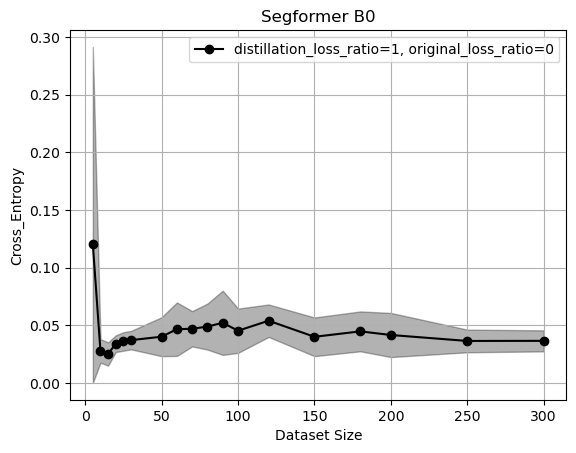

In [2]:
import os
import json

print("train_size size = ", np.array(train_sizes).size)
print("mean_val_losses size = ", np.array(mean_val_losses).size)
print("std_val_losses size = ", np.array(std_val_losses).size)
print("train_size = ", train_sizes)
print("mean_val_losses = ", mean_val_losses)
print("std_val_losses = ", std_val_losses)

results_dir = os.path.join(os.getcwd(), 'TrainingRecords', 'results_KD_segformer_0616')
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

results = {
    "train_sizes": train_sizes,
    "mean_val_losses": mean_val_losses,
    "std_val_losses": std_val_losses
}
json_path = os.path.join(results_dir, f"results_KD_segformer_0616_{int(teacher_ratio*100)}.json")
with open(json_path, 'w') as json_file:
    json.dump(results, json_file, indent=4)

plt.figure()
plt.plot(train_sizes, mean_val_losses, marker='o', color='black', label=f'distillation_loss_ratio={teacher_ratio}, original_loss_ratio={round(1-teacher_ratio, 2)}')
plt.fill_between(train_sizes, np.maximum(0, np.array(mean_val_losses) - np.array(std_val_losses)), 
                 np.array(mean_val_losses) + np.array(std_val_losses), color='black', alpha=0.3)
plt.title('Segformer B0')
plt.xlabel('Dataset Size')
plt.ylabel('Cross_Entropy')
plt.grid(True)
plt.legend()
plt.savefig(os.path.join(results_dir, f"results_KD_segformer_0616_{int(teacher_ratio*100)}.png"))

plt.show()